In [1]:
#! conda install --channel conda-forge lightkurve

In [2]:
#IMPORT RELEVANT LIBRARIES
import lightkurve as lk
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np

In [3]:
#DOWNLOAD RELEVANT KEPLER DATA
lcfs = lk.search_lightcurvefile('Kepler-447b', mission='Kepler',quarter = None).download_all()

In [4]:
#DISPLAY DATA QUARTERS
lcfs

LightCurveFileCollection of 15 objects:
	KIC 11017901 (15 KeplerLightCurveFiles) Quarters: 0,1,2,3,4,5,6,7,9,10,11,13,14,15,17

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

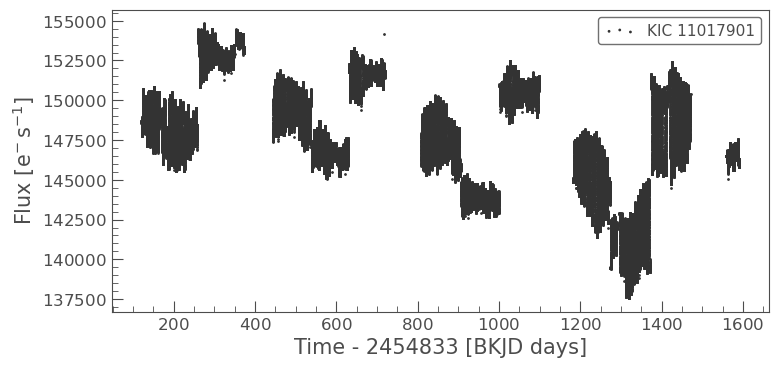

In [5]:
#STITCH QUARTERS TOGETHER
lcfs.PDCSAP_FLUX.stitch(corrector_func=lambda lc:lc).scatter(normalize=False)

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

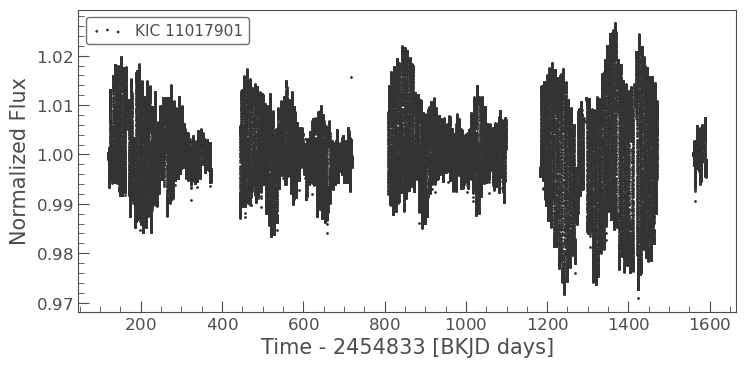

In [6]:
#STITCH QUARTERS WITH NORMALISATION
stitched_lc = lcfs.PDCSAP_FLUX.stitch()
stitched_lc = stitched_lc.remove_nans()  #remember to remove nans
stitched_lc.scatter()

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

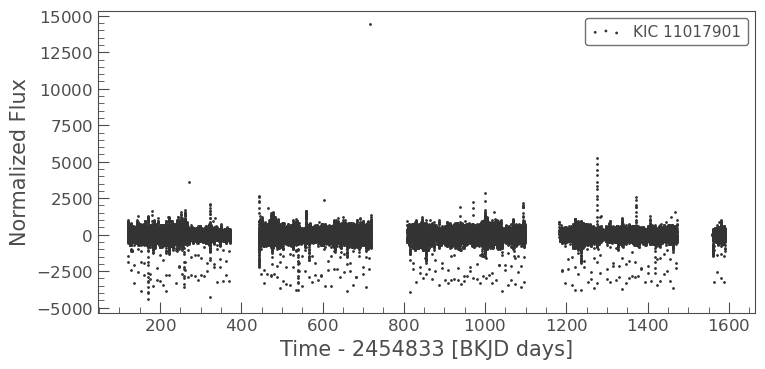

In [7]:
#STITCH QUARTERS WITH NORMALISATION AND CORRECTOR FUNCTION
def my_custom_corrector_func(lc):
    corrected_lc = lc.normalize().flatten(window_length=101)
    corrected_lc -= 1
    corrected_lc = corrected_lc/10**-6
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=my_custom_corrector_func)
stitched_lc = stitched_lc.remove_nans()
stitched_lc.scatter()

(200.0, 220.0)

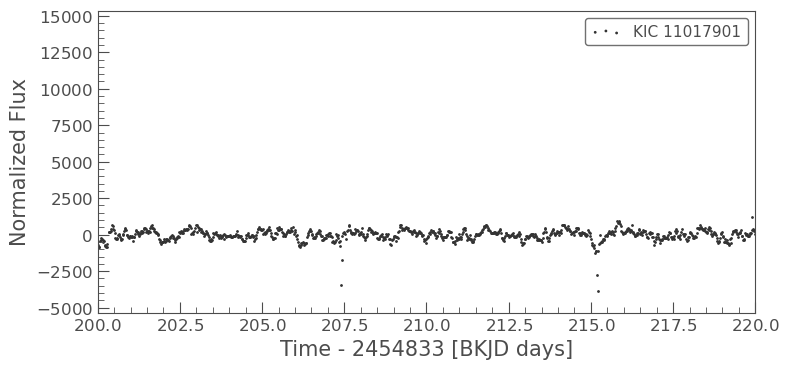

In [8]:
#DISPLAY SHORT RANGE TO SHOW TRANSITS CLEARLY
stitched_lc.scatter()
plt.xlim([200,220])

7.7942530000061865 d


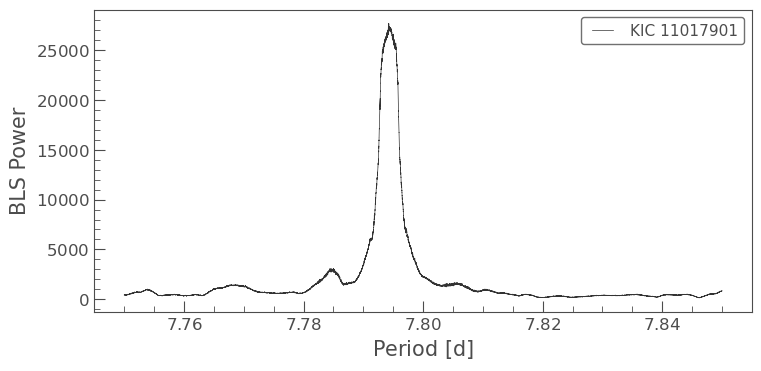

In [9]:
#OBTAIN TRANSIT PERIOD USING PERIODOGRAM
periodogram = stitched_lc.to_periodogram(method="bls", period=np.arange(7.75, 7.85, 0.000001))
periodogram.plot()
best_fit_period = periodogram.period_at_max_power
print(best_fit_period)

<AxesSubplot:xlabel='Phase', ylabel='Normalized Flux'>

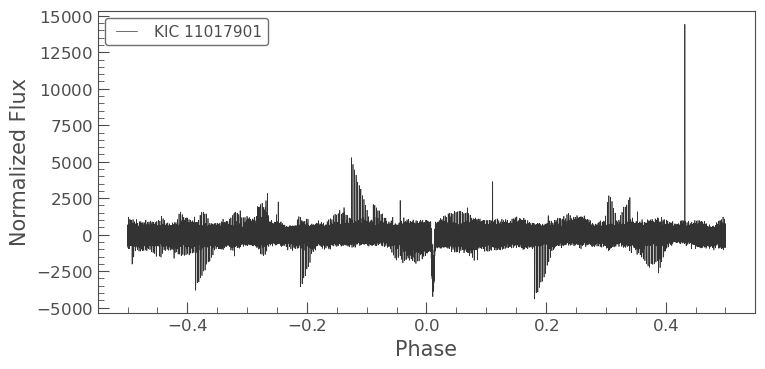

In [10]:
#FOLD LIGHTCURVE OVER TRANSIT PERIOD
folded = stitched_lc.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power)
folded.plot()

(-150.0, 150.0)

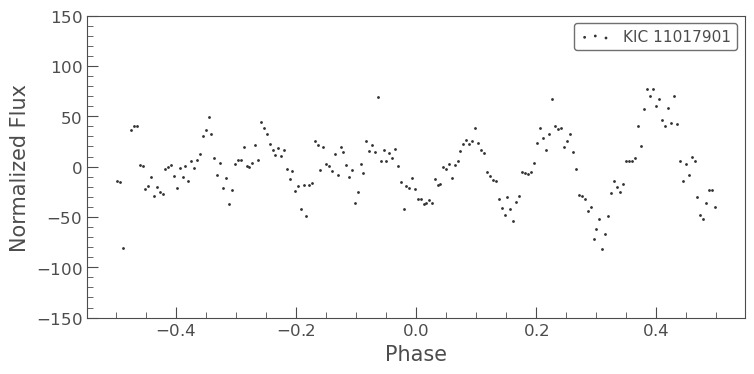

In [11]:
#ISOLATE SECONDARY ECLIPSE AND BIN DATA
final = stitched_lc.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power + 3.85).bin(binsize = 250).scatter()
final.plot()
plt.ylim([-150, 150])
#plt.xlim([0, 1])

In [12]:
#DEFINE NECESSARY CONSTANTS
i = 86.55*(2*np.pi/360)
a = 0.0769*149597870700
u = 0.4451
y = 0.2297 

aRstar = (0.0769*149597870700)/(1.05*695700000)
Mplan = 1.37*1.898130*(10**27)
Mstar = 1.0*1.989100*(10**30)
phaseM = 0.5
RpRs = (1.65*69911000)/(1.05*695700000)

In [13]:
#DEFINE PHASE FIT FUNCTION
def test_func(x, free, f0, Ae, Ad, Ap, Decl):
    global z, alpha, f1, f2, cosz, Pecl
    r = aRstar*((1-(((np.sin(i))**2)*((np.cos(2*free*np.pi*(np.array(xpos)-phaseM)))**2)))**0.5)
    Pecl = np.array([])
    
    for value in np.array(r):
        if value >= 1+RpRs:
            p = 0
        elif value <= 1-RpRs:
            p = 1
        else:
            costheta1 = (1+(value**2)-(RpRs**2))/(2*value)
            costheta2 = ((value**2)+(RpRs**2)-1)/(2*RpRs*value)
            theta1 = np.arccos(costheta1)
            theta2 = np.arccos(costheta2)
            
            p = ((1/(np.pi*(RpRs**2)))*(theta1 - (np.sin(theta1)*costheta1)))+((1/np.pi)*(theta2 - (np.sin(theta2)*costheta2)))
        Pecl = np.append(Pecl, p)
    
    alpha = ((25*u)/(24*(15+u)))*((y+2)/(y+1))
    f0 = f0
    f1 = (((3*alpha)/(aRstar))*(((5*((np.sin(i))**2))-4)/np.sin(i)))
    f2 = (5*alpha*(Mplan/Mstar)*((aRstar)**-3)*np.sin(i))
    cosz = (-np.sin(i))*(np.cos(2*np.pi*np.array(x)))
    z = np.arccos(cosz)
    
    Fe = -Ae*((np.cos(2*np.pi*2*np.array(x)))+(f1*(np.cos(2*np.pi*np.array(x))))+(f2*(np.cos(2*np.pi*3*np.array(x)))))
    Fd = Ad*(np.sin(2*np.pi*np.array(x)))
    Fp = Ap*((np.sin(z)+((np.pi-z)*cosz))/np.pi)
    Fecl = Decl*(1-Pecl)
    
    return f0+Fe+Fd+Fp+Fecl



In [14]:
#SET DATA LIMITS
data = final.collections[0].get_offsets() + 0.5
xpos = ([])
ypos = ([])
xtransit = ([])
for _, item in enumerate(data):
    x = item[0]
    y = item[1]
    if abs(y) < 100:
        xpos.append(x)
        ypos.append(y)

free; 1.0081372414383014
f0; -42.20826442200516
Ae; -0.48811644832771744
Ad; 1.6649262898744113
Ap; -7.453836022460366
Decl; 46.079785977238096



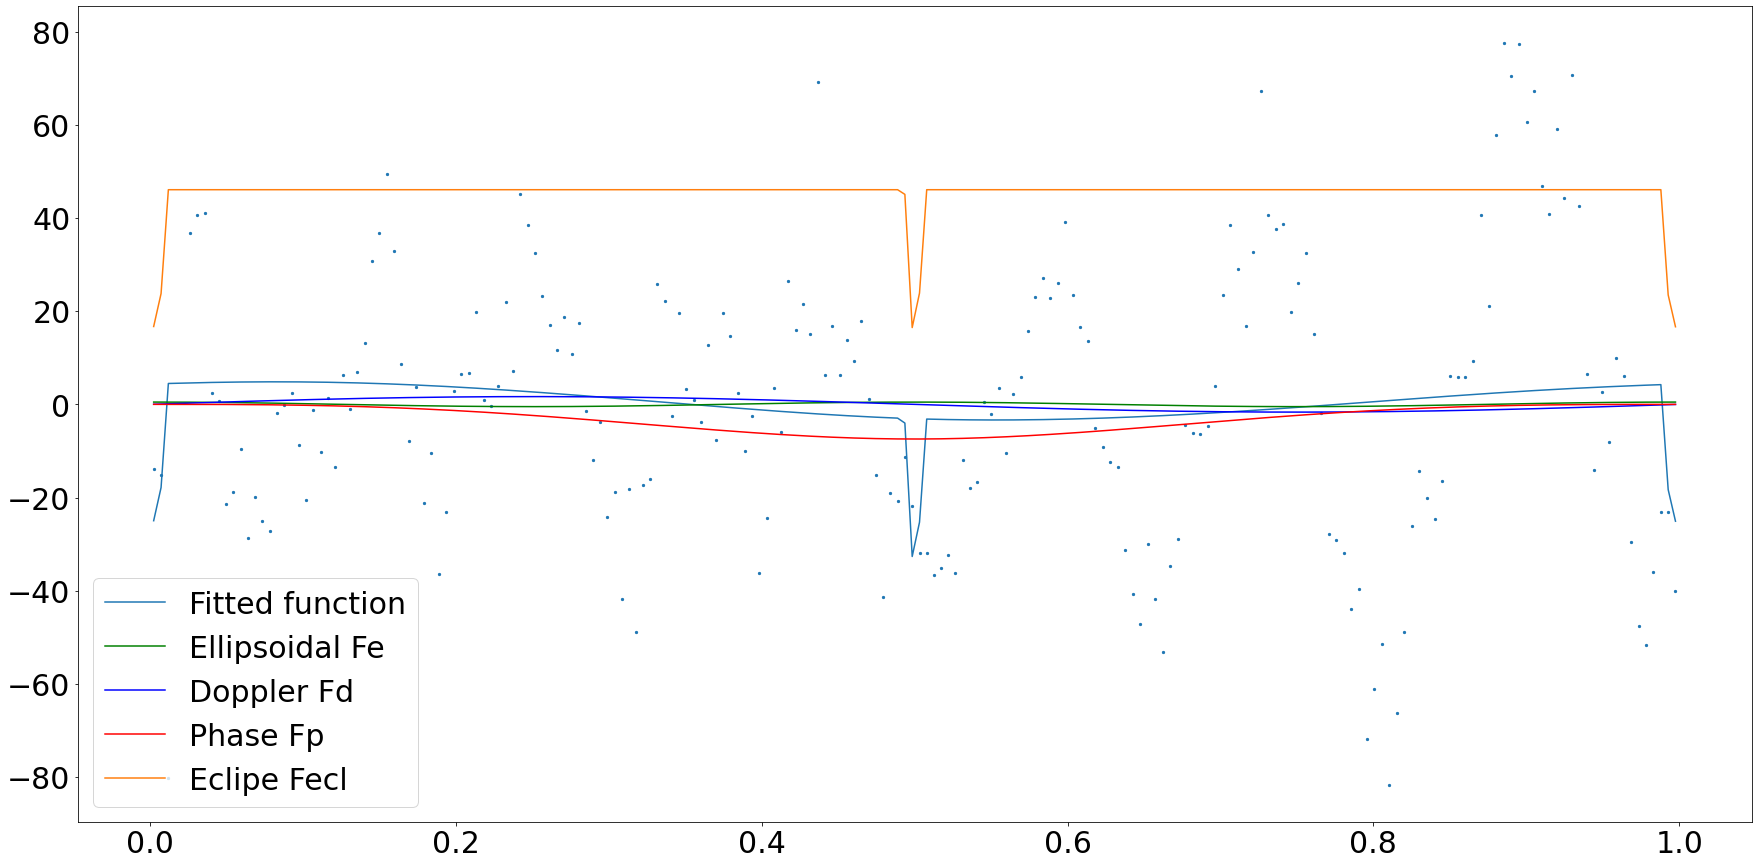

In [15]:
#PLOT PHASE FUNCTION WITH ALL CONTRIBUTIONS
font = {
        'size'   : 30}

plt.rc('font', **font)
plt.figure(figsize=(30,15))
plt.scatter(xpos, ypos, s=5)

params, params_covariance = optimize.curve_fit(test_func, xpos, ypos, p0=[1, -10, 58, 5, 50, 50])
print('free; {}\nf0; {}\nAe; {}\nAd; {}\nAp; {}\nDecl; {}\n'.format(params[0], params[1], params[2], params[3], params[4], params[5]))
plt.plot(xpos, test_func(xpos, params[0], params[1], params[2], params[3], params[4], params[5]), label='Fitted function')
plt.plot(xpos, -params[2]*((np.cos(2*np.pi*2*np.array(xpos)))+(f1*(np.cos(2*np.pi*np.array(xpos))))+(f2*(np.cos(2*np.pi*3*np.array(xpos))))), 'g-', label='Ellipsoidal Fe')#Ellipsoidal Fe
plt.plot(xpos, params[3]*(np.sin(2*np.pi*np.array(xpos))), 'b-', label='Doppler Fd')#Doppler Fd
plt.plot(xpos, params[4]*((np.sin(z)+((np.pi-z)*cosz))/np.pi), 'r-', label='Phase Fp')#Phase Fp
plt.plot(xpos, params[5]*(1-Pecl), label='Eclipe Fecl')#Eclipe Fecl
plt.legend()

plt.show()

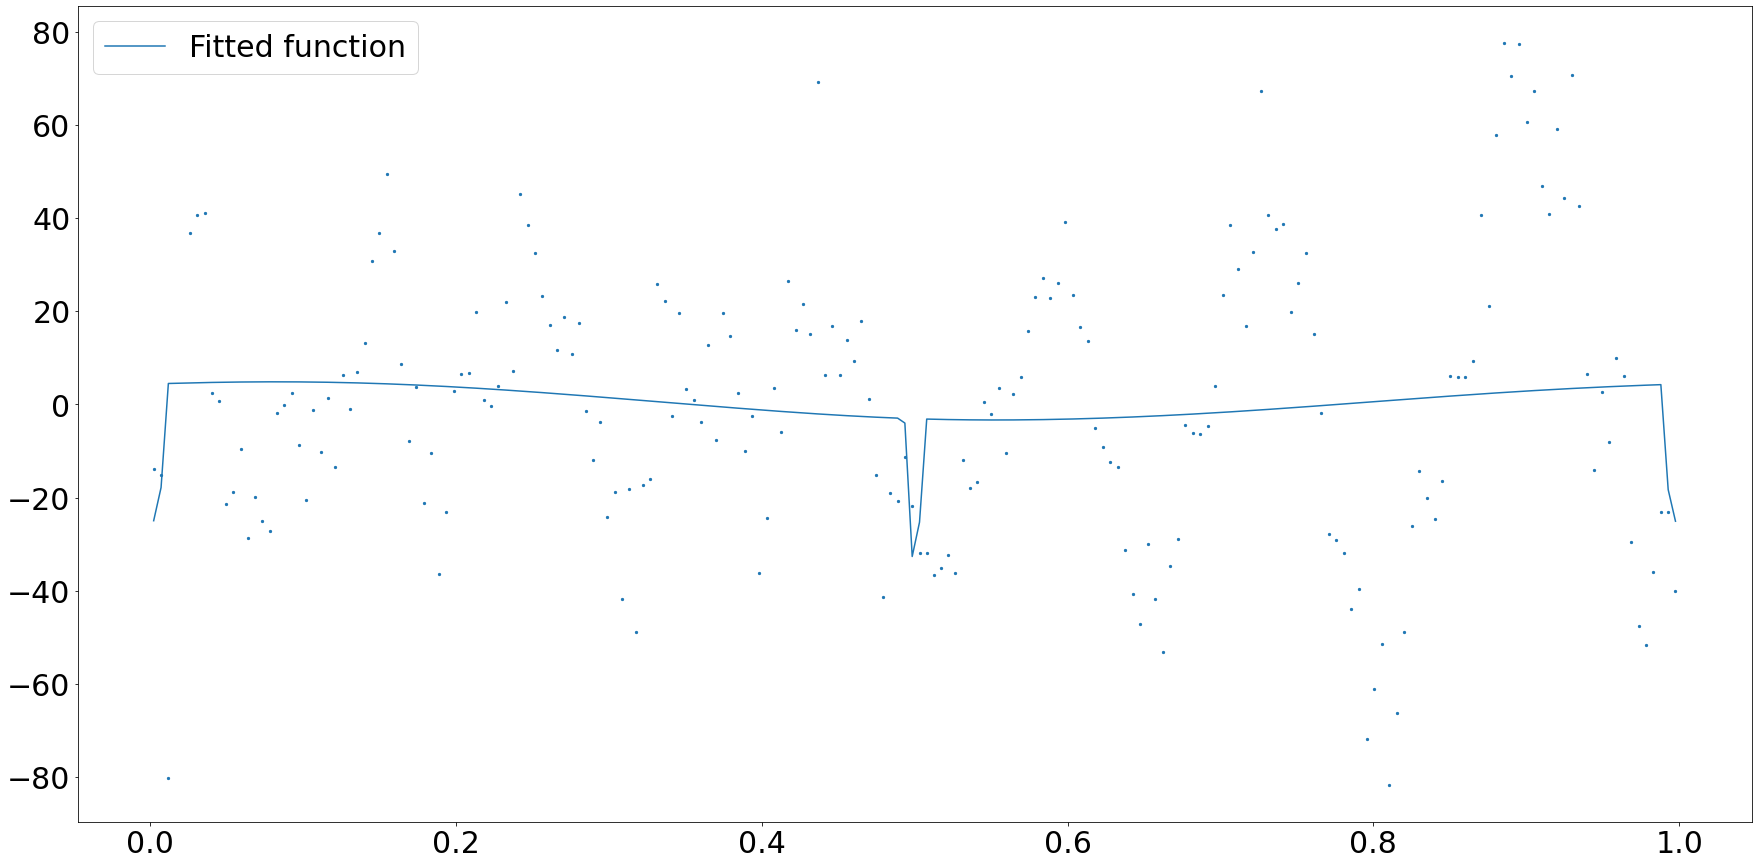

In [16]:
#PLOT PHASE FUNCTION ALONE
font = {
        'size'   : 30}

plt.rc('font', **font)
plt.figure(figsize=(30,15))
plt.scatter(xpos, ypos, s=5)

params, params_covariance = optimize.curve_fit(test_func, xpos, ypos, p0=[1, -10, 58, 5, 50, 50])
plt.plot(xpos, test_func(xpos, params[0], params[1], params[2], params[3], params[4], params[5]), label='Fitted function')
plt.legend()

plt.show()

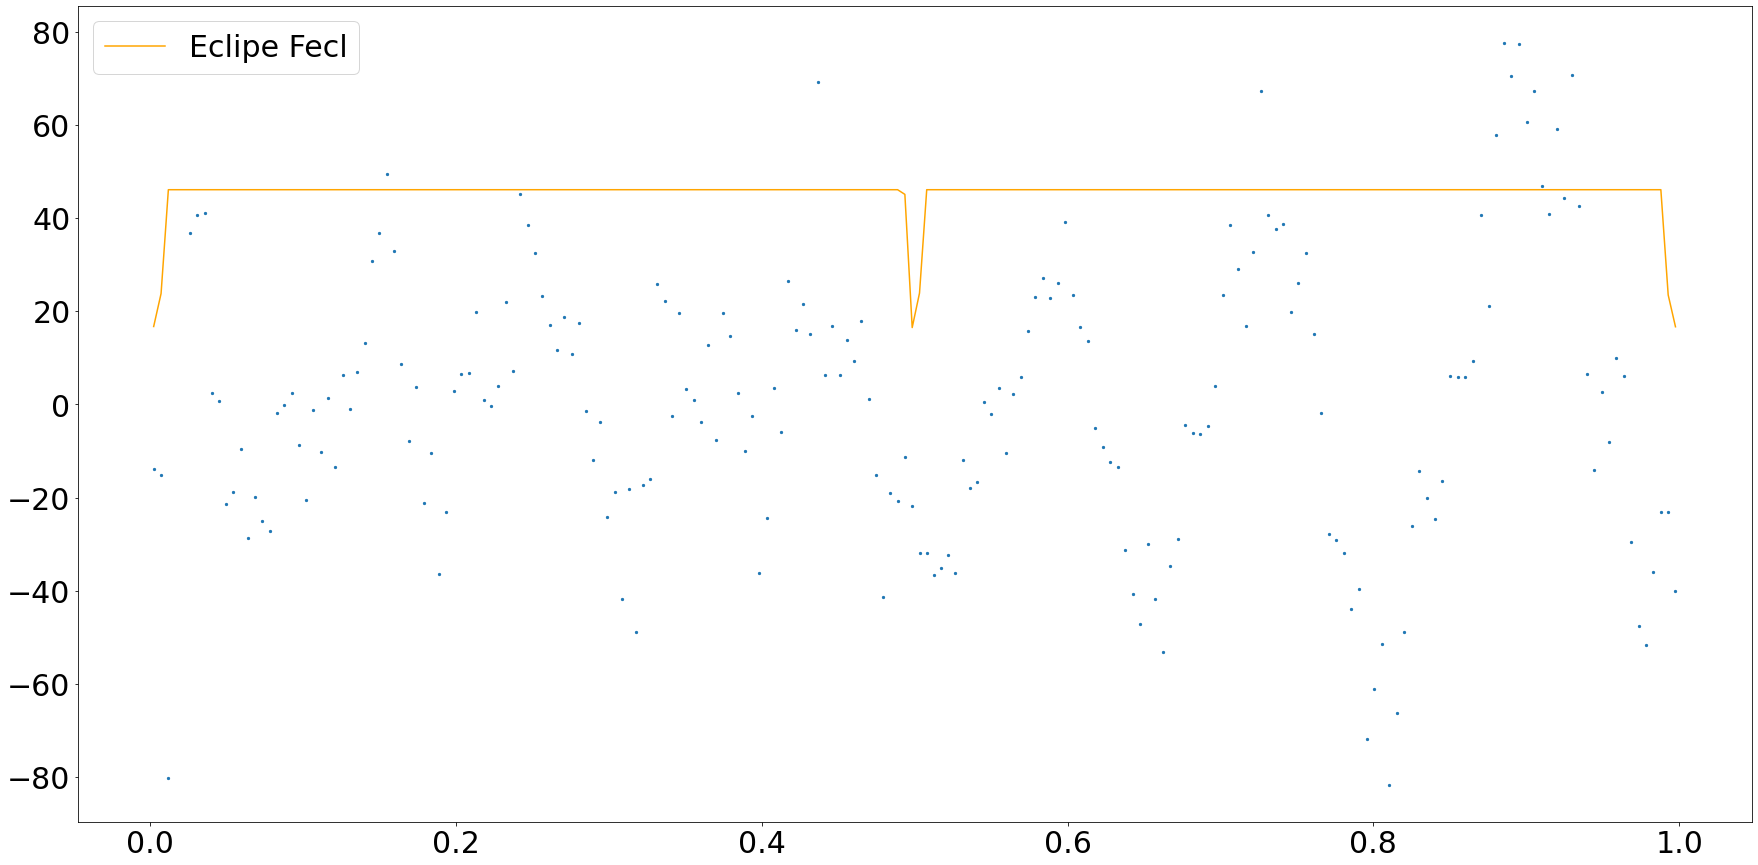

In [17]:
#PLOT SECONDARY ECLIPSE ALONE
font = {
        'size'   : 30}

plt.rc('font', **font)
plt.figure(figsize=(30,15))
plt.scatter(xpos, ypos, s=5)

params, params_covariance = optimize.curve_fit(test_func, xpos, ypos, p0=[1, -10, 58, 5, 50, 50])
plt.plot(xpos, params[5]*(1-Pecl), color='orange', label='Eclipe Fecl')#Eclipe Fecl
plt.legend()

plt.show()